# 1. Load Dataset

In [103]:
import pandas as pd

file_path = "../data/dataset.json"
df = pd.read_json(file_path)

df.head()

,timestamp,text,text_id,user,user_id
0,2024-10-31,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112
1,2024-10-31,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430
2,2024-10-31,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642
3,2024-10-31,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480
4,2024-10-31,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936


# 2. Run Sentiment Analysis to Get Labels and Confidence Scores

In [ ]:
from transformers import pipeline

# Load the sentiment analysis pipeline with the Twitter-specific model
sentiment_pipeline = pipeline(
    "sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

# Apply the pipeline to the 'text' column
results = df["text"].apply(sentiment_pipeline)

# Extract the label and score for each result and add them as new columns
df["sentiment_label"] = results.apply(lambda x: x[0]["label"])
df["sentiment_score"] = results.apply(lambda x: x[0]["score"])

# Display the updated DataFrame
df.head()

In [4]:
# Save the DataFrame to a CSV file
output_csv_path = "../data/sentiment_analysis_results.csv"  # Specify your file name
df.to_csv(output_csv_path, index=False)

print(f"DataFrame saved to {output_csv_path}")

DataFrame saved to ../data/sentiment_analysis_results.csv


# 3. Separate by Sentiment Label

In [109]:
# Create separate lists for each sentiment
positive_scores = df.loc[
    df["sentiment_label"] == "positive", "sentiment_score"
].tolist()
neutral_scores = df.loc[df["sentiment_label"] == "neutral", "sentiment_score"].tolist()
negative_scores = df.loc[
    df["sentiment_label"] == "negative", "sentiment_score"
].tolist()

# Print the results for verification
print(f"Number of Positive Scores: {len(positive_scores)}")
print(f"Number of Neutral Scores: {len(neutral_scores)}")
print(f"Number of Negative Scores: {len(negative_scores)}")

Number of Positive Scores: 39298
Number of Neutral Scores: 17935
Number of Negative Scores: 13027


# 4. Apply K-Means to Each Group to determine the strength of the sentiment

In [111]:
from sklearn.cluster import KMeans
import numpy as np


# Define a function to apply K-Means clustering
def apply_kmeans(scores, n_clusters=3):
    scores_array = np.array(scores).reshape(-1, 1)  # Reshape for K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Initialize K-Means
    clusters = kmeans.fit_predict(scores_array)  # Fit and predict clusters
    return clusters, kmeans.cluster_centers_


# Apply K-Means to each sentiment group
positive_clusters, positive_centers = apply_kmeans(positive_scores)
neutral_clusters, neutral_centers = apply_kmeans(neutral_scores)
negative_clusters, negative_centers = apply_kmeans(negative_scores)

# Display cluster centers for verification
print(f"Positive Cluster Centers: {sorted(positive_centers.flatten())}")
print(f"Neutral Cluster Centers: {sorted(neutral_centers.flatten())}")
print(f"Negative Cluster Centers: {sorted(negative_centers.flatten())}")

Positive Cluster Centers: [np.float64(0.5943230856777919), np.float64(0.8043295104289402), np.float64(0.9542473458014581)]
Neutral Cluster Centers: [np.float64(0.54081104655), np.float64(0.6979260955666962), np.float64(0.8720885476953795)]
Negative Cluster Centers: [np.float64(0.557697234616176), np.float64(0.7310676325058318), np.float64(0.8803989664225385)]


In [112]:
from sklearn.metrics import silhouette_score


# Define a function to calculate silhouette scores for already applied K-Means
def evaluate_silhouette(scores, clusters):
    scores_array = np.array(scores).reshape(-1, 1)  # Reshape for Silhouette Score
    if len(scores) > len(np.unique(clusters)):  # Ensure enough samples for evaluation
        sil_score = silhouette_score(scores_array, clusters)
        print(f"Silhouette Score: {sil_score:.4f}")
    else:
        sil_score = None
        print("Insufficient samples to compute Silhouette Score.")
    return sil_score


# Evaluate silhouette score for each sentiment group
print("\nPositive Sentiment:")
positive_silhouette = evaluate_silhouette(positive_scores, positive_clusters)

print("\nNeutral Sentiment:")
neutral_silhouette = evaluate_silhouette(neutral_scores, neutral_clusters)

print("\nNegative Sentiment:")
negative_silhouette = evaluate_silhouette(negative_scores, negative_clusters)


Positive Sentiment:
Silhouette Score: 0.6707

Neutral Sentiment:
Silhouette Score: 0.6043

Negative Sentiment:
Silhouette Score: 0.5948


# 5. Combine Sentiment Label with Strength

In [114]:
# Define a function to map clusters to Weak, Mid, Strong
def assign_cluster_labels(scores, clusters, centers):
    # Map each cluster to Weak, Mid, or Strong based on sorted cluster centers
    sorted_centers = sorted((val, idx) for idx, val in enumerate(centers.flatten()))
    cluster_mapping = {
        sorted_centers[0][1]: "Weak",
        sorted_centers[1][1]: "Mid",
        sorted_centers[2][1]: "Strong",
    }

    # Map cluster assignments to labels
    cluster_labels = [cluster_mapping[c] for c in clusters]
    return cluster_labels


# Assign labels for each sentiment group
positive_labels = assign_cluster_labels(
    positive_scores, positive_clusters, positive_centers
)
neutral_labels = assign_cluster_labels(
    neutral_scores, neutral_clusters, neutral_centers
)
negative_labels = assign_cluster_labels(
    negative_scores, negative_clusters, negative_centers
)

# Add cluster labels back to the original DataFrame
df["strength"] = None  # Initialize the 'strength' column

df.loc[df["sentiment_label"] == "positive", "strength"] = positive_labels
df.loc[df["sentiment_label"] == "neutral", "strength"] = neutral_labels
df.loc[df["sentiment_label"] == "negative", "strength"] = negative_labels

# Display a few rows to verify
print("Updated DataFrame with strength labels:")
display(df[["text", "sentiment_label", "sentiment_score", "strength"]].head())

Updated DataFrame with strength labels:


,text,sentiment_label,sentiment_score,strength
0,Running a business means juggling countless ad...,positive,0.781216,Mid
1,Liz Truss is walking in the lingering shadow o...,negative,0.882852,Strong
2,The UK is bracing for war as government buildi...,negative,0.551017,Weak
3,Marrying a second or third cousin once removed...,positive,0.747033,Mid
4,It's truly disgraceful how the Indian National...,negative,0.943839,Strong


In [11]:
output_csv_path = "../data/strength_dataset.csv"  # Specify the desired file path

# Save the updated DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

## 6. Classyfiying the texts into topics

In [12]:
df = pd.read_csv("../data/strength_dataset.csv")

# Initialize the topic classification pipeline
topic_pipeline = pipeline(
    "text-classification", model="cardiffnlp/tweet-topic-21-multi", truncation=True
)

# Classify tweets into topics using the topic classification pipeline
df["topic"] = df["text"].apply(lambda x: topic_pipeline(x)[0]["label"])

Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
# Save the updated DataFrame with the topic labels to a CSV file
output_csv_path = (
    "../data/sentiment_analysis_with_topics.csv"  # Specify the output file path
)

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

In [116]:
df.head()

,timestamp,text,text_id,user,user_id,sentiment_label,sentiment_score,strength,topic
0,2024-10-31 00:00:00,Running a business means juggling countless ad...,2018569761,danielwoodard,1077866112,positive,0.781216,Mid,business_&_entrepreneurs
1,2024-10-31 00:00:00,Liz Truss is walking in the lingering shadow o...,2092717718,nelsonjacqueline,1089670430,negative,0.882852,Strong,news_&_social_concern
2,2024-10-31 00:00:00,The UK is bracing for war as government buildi...,2059143248,ihooper,1007478642,negative,0.551017,Weak,news_&_social_concern
3,2024-10-31 00:00:00,Marrying a second or third cousin once removed...,2008209828,wrightnicholas,1039258480,positive,0.747033,Mid,family
4,2024-10-31 00:00:00,It's truly disgraceful how the Indian National...,2001239278,michael51,1021455936,negative,0.943839,Strong,news_&_social_concern


# 7. Visualize the Results

## Number and Share of Tweets per Topic


Plot saved to plots/number_tweets_per_topic_fixed.png


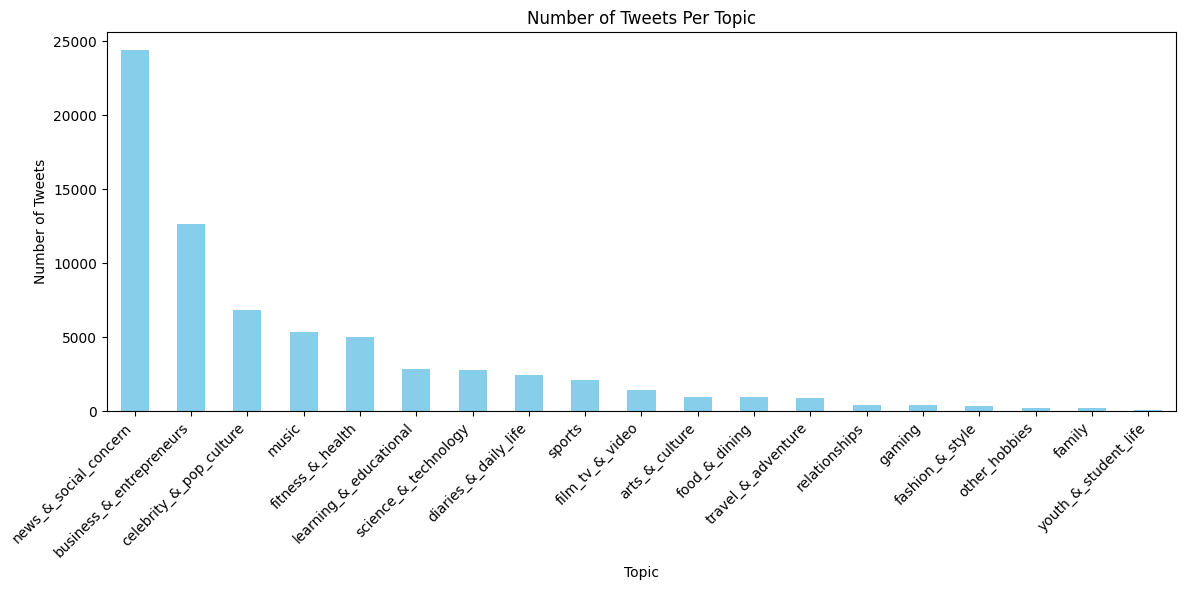

In [117]:
import matplotlib.pyplot as plt

# Count the number of tweets for each topic
topic_counts = df["topic"].value_counts()

# Bar plot
plt.figure(figsize=(12, 6))
topic_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Tweets Per Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")

# Adjust the layout to prevent label cutoff
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save the plot
output_path = "plots/number_tweets_per_topic_fixed.png"
plt.savefig(output_path, dpi=300)
print(f"Plot saved to {output_path}")

# Show the plot
plt.show()

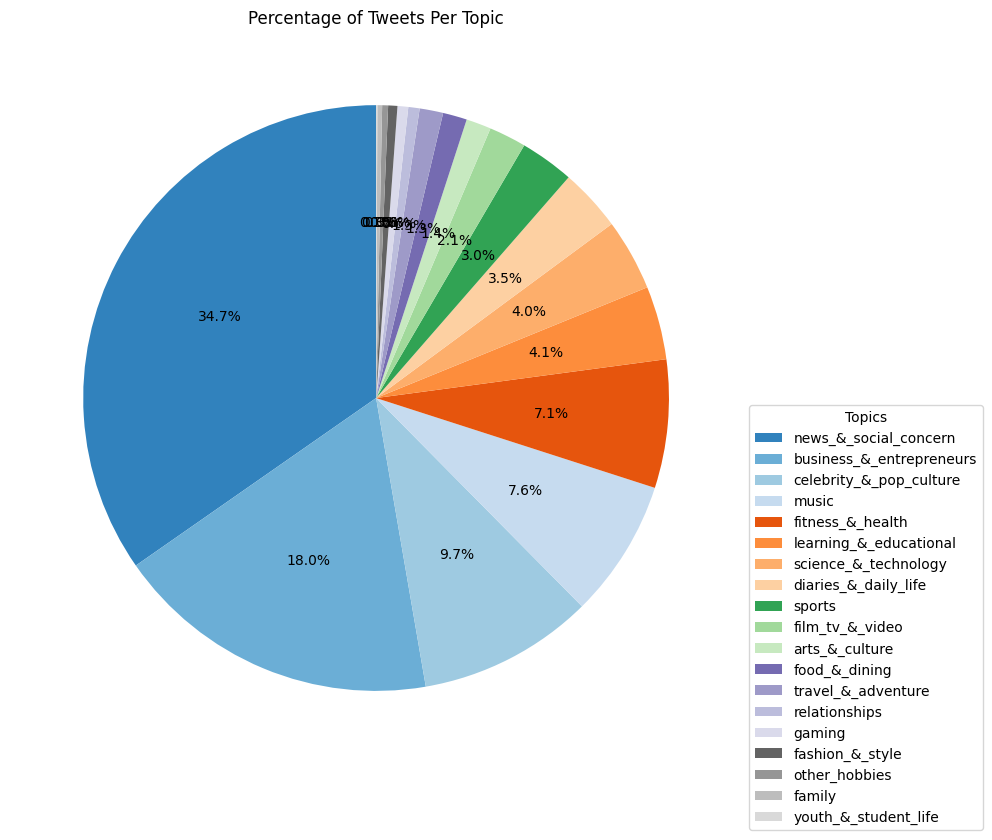

In [118]:
plt.figure(figsize=(10, 10))
topic_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    colormap="tab20c",
    labels=None,  # Remove labels from slices
)
plt.legend(
    labels=topic_counts.index, loc="upper left", bbox_to_anchor=(1, 0.5), title="Topics"
)
plt.title("Percentage of Tweets Per Topic")
plt.ylabel("")
plt.tight_layout()
plt.savefig("plots/percentage_tweets_topic.png", dpi=300)
plt.show()

## Sentiment Distribution by Topic

Plot saved to plots/sentiment_distribution_topics_sorted.png


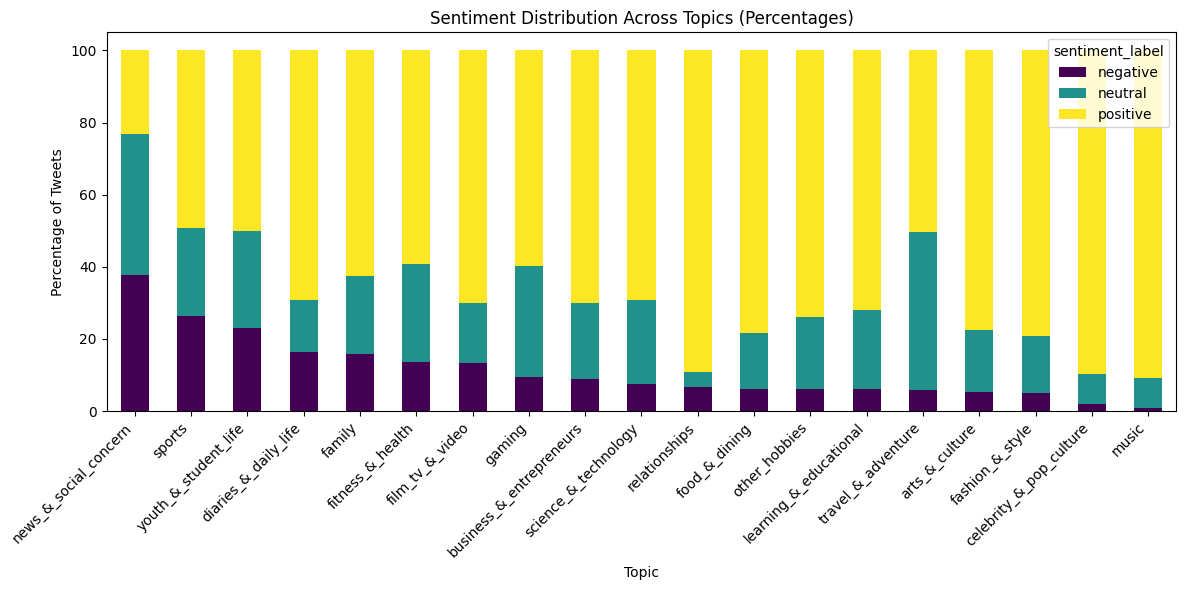

In [119]:
# Group by topic and sentiment label, then normalize to percentages
sentiment_topic_counts = (
    df.groupby(["topic", "sentiment_label"]).size().unstack(fill_value=0)
)

# Convert to percentages
sentiment_topic_percentages = (
    sentiment_topic_counts.div(sentiment_topic_counts.sum(axis=1), axis=0) * 100
)

# Sort by the percentage of negative sentiment in descending order
sentiment_topic_percentages = sentiment_topic_percentages.sort_values(
    by="negative", ascending=False
)

# Stacked bar plot with percentages
ax = sentiment_topic_percentages.plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="viridis"
)
plt.title("Sentiment Distribution Across Topics (Percentages)")
plt.xlabel("Topic")
plt.ylabel("Percentage of Tweets")
plt.xticks(rotation=45, ha="right")

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Save the plot
output_path = "plots/sentiment_distribution_topics_sorted.png"
plt.savefig(output_path, dpi=300)
print(f"Plot saved to {output_path}")

# Show the plot
plt.show()

## Overall Sentiment Distribution

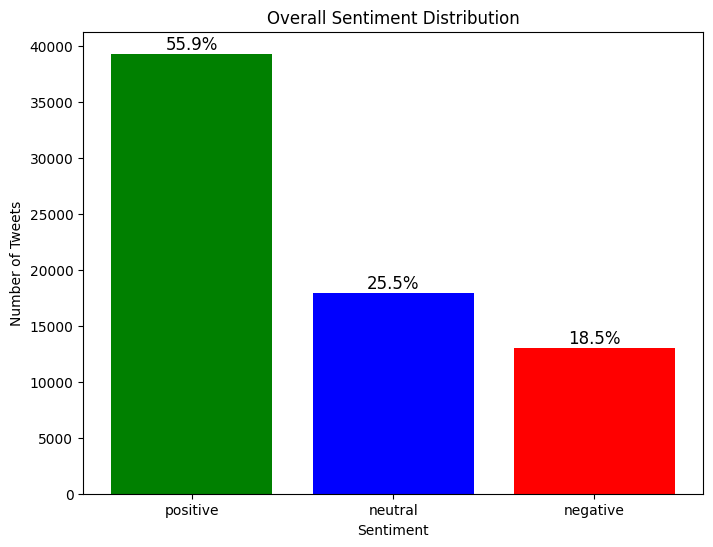

In [120]:
import matplotlib.pyplot as plt

# Count sentiment labels
sentiment_counts = df["sentiment_label"].value_counts()

# Calculate percentages
total_tweets = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total_tweets) * 100

# Bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.index, sentiment_counts, color=["green", "blue", "red"])

# Annotate bars with percentages
for bar, percentage in zip(bars, sentiment_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate: center of the bar
        bar.get_height() + 50,  # y-coordinate: slightly above the bar
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12,
    )

# Add titles and labels
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
output_path = "plots/overall_sentiment_distribution.png"
plt.savefig(output_path, dpi=300)
plt.show()

# 8. Timestamp Analysis

## Load the Dataset and Fix Timestamps

In [121]:
import pandas as pd

# Load the original dataset.json
original_df = pd.read_json("../data/dataset.json")

# Load the sentiment analysis results
sentiment_df = pd.read_csv("../data/sentiment_analysis_with_topics.csv")

# Select the desired columns from the sentiment analysis dataset
sentiment_df = sentiment_df[
    ["text_id", "sentiment_label", "sentiment_score", "strength", "topic"]
]

# Merge the datasets on the `text_id` column
fixed_df = pd.merge(original_df, sentiment_df, on="text_id", how="left")

# Save the fixed dataset to a JSON file
fixed_df.to_json("../data/fixed_dataset.json", orient="records", lines=False)

In [122]:
df = pd.read_json("../data/fixed_dataset.json")

In [123]:
# Convert timestamp to numerical format (Piet version)

# get the earliest timestamp
earliest_timestamp = df["timestamp"].min()

# use the earliest timestamp as the base, and convert the timestamp to seconds
df["timestamp"] = (df["timestamp"] - earliest_timestamp).dt.total_seconds()

df["timestamp"]

0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
          ...   
70255    86392.0
70256    86392.0
70257    86394.0
70258    86398.0
70259    86399.0
Name: timestamp, Length: 70260, dtype: float64

# Activity over Time

/var/folders/1j/3_89n5mj6ylf4s2rhq4hf4840000gn/T/ipykernel_23943/2797761558.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_trend = df.groupby(time_bins).size()


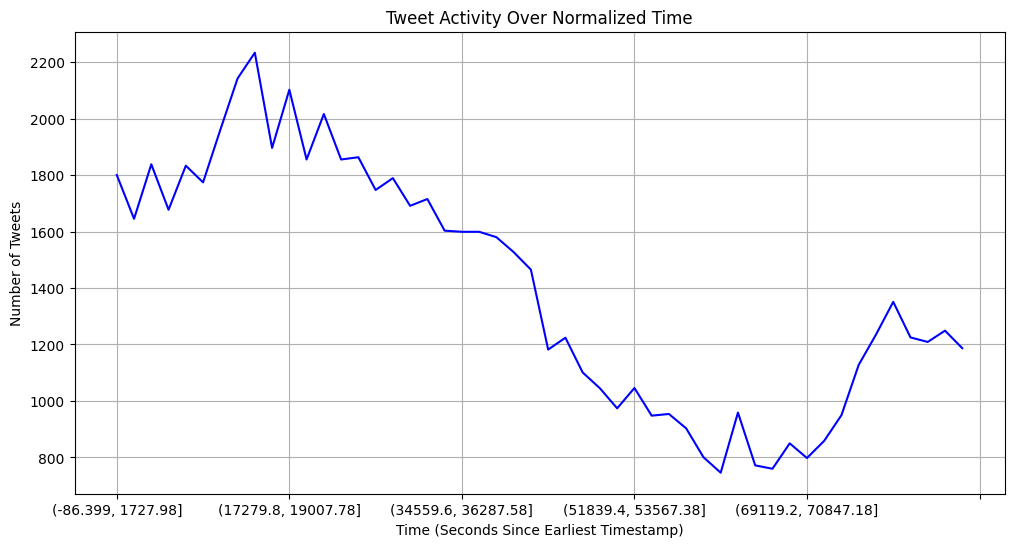

In [125]:
import matplotlib.pyplot as plt

# Group by timestamp bins (e.g., 50 bins for better granularity)
time_bins = pd.cut(df["timestamp"], bins=50)
activity_trend = df.groupby(time_bins).size()

# Plot tweet activity trend
plt.figure(figsize=(12, 6))
activity_trend.plot(kind="line", color="blue")
plt.title("Tweet Activity Over Normalized Time")
plt.xlabel("Time (Seconds Since Earliest Timestamp)")
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.savefig("plots/tweet_activity_over_time.png", dpi=300)
plt.show()

## Sentiment Analysis Over Time

/var/folders/1j/3_89n5mj6ylf4s2rhq4hf4840000gn/T/ipykernel_23943/1221113664.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_sentiment_trend = df.groupby([pd.cut(df['timestamp'], bins=50), 'sentiment_label']).size().unstack(fill_value=0)


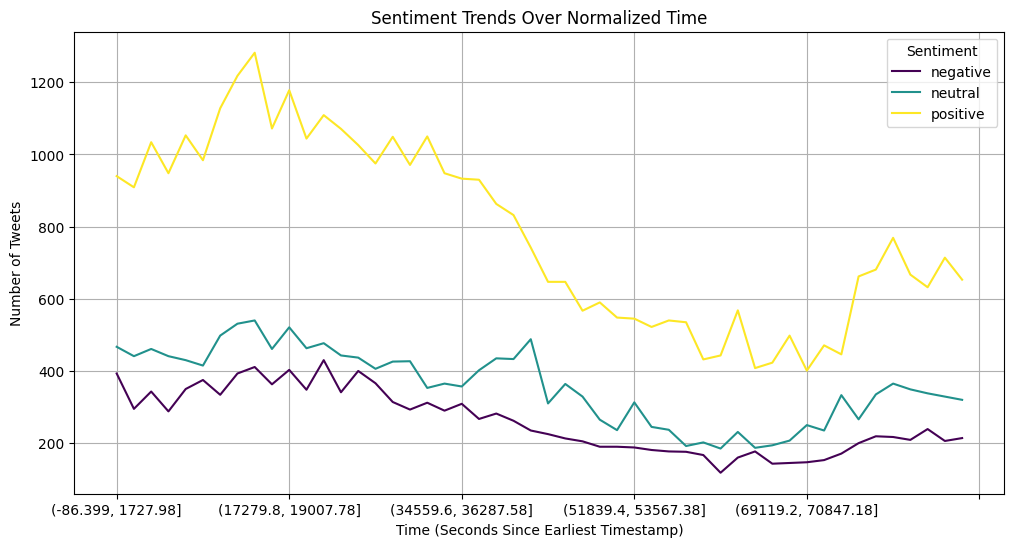

In [126]:
# Group by normalized time bins and sentiment
time_sentiment_trend = (
    df.groupby([pd.cut(df["timestamp"], bins=50), "sentiment_label"])
    .size()
    .unstack(fill_value=0)
)

# Plot sentiment trends
time_sentiment_trend.plot(kind="line", figsize=(12, 6), colormap="viridis")
plt.title("Sentiment Trends Over Normalized Time")
plt.xlabel("Time (Seconds Since Earliest Timestamp)")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.grid(True)
plt.savefig("plots/sentiment_trends_over_time.png", dpi=300)
plt.show()

# 9. Hypothesis

# Users who predominantly post tweets with negative sentiment tend to form denser clusters in the social network.

## 1. Load Data

In [127]:
fixed_dataset = pd.read_json("../data/fixed_dataset.json")  # Your dataset
edge_df = pd.read_csv("../data/graph.csv")  # Graph edge list
confidence_df = fixed_dataset[["user_id", "sentiment_score", "sentiment_label"]]

## 2. Aggregate Sentiment Data by user_id

In [128]:
confidence_aggregated = confidence_df.groupby("user_id", as_index=False).agg(
    {
        "sentiment_score": "mean",
        "sentiment_label": lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan,
    }
)

# Convert to dictionary for graph attributes
confidence_dict = confidence_aggregated.set_index("user_id")[
    ["sentiment_score", "sentiment_label"]
].to_dict(orient="index")

## 3. Build Graph

In [129]:
import networkx as nx

G = nx.Graph()
for _, row in edge_df.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["weight"])

# Attach sentiment scores and labels as node attributes
nx.set_node_attributes(G, confidence_dict)

## 4. Detect Communities

In [130]:
from networkx.algorithms import community

communities = community.greedy_modularity_communities(G)

## 5. Compute Cluster Metrics

In [131]:
cluster_stats = {
    "cluster_id": [],
    "density": [],
    "avg_confidence": [],
    "negative_user_ratio": [],
}

for i, community_nodes in enumerate(communities):
    subgraph = G.subgraph(community_nodes)
    density = nx.density(subgraph)
    sentiment_scores = [
        G.nodes[node].get("sentiment_score", np.nan) for node in community_nodes
    ]
    sentiment_labels = [
        G.nodes[node].get("sentiment_label", None) for node in community_nodes
    ]

    avg_confidence = np.nanmean(sentiment_scores)
    negative_ratio = sum(1 for label in sentiment_labels if label == "negative") / len(
        community_nodes
    )

    cluster_stats["cluster_id"].append(i)
    cluster_stats["density"].append(density)
    cluster_stats["avg_confidence"].append(avg_confidence)
    cluster_stats["negative_user_ratio"].append(negative_ratio)

cluster_stats_df = pd.DataFrame(cluster_stats)

## 6. Analyze Relationship Between Negative Sentiment and Density

In [132]:
from scipy import stats

df_clean = cluster_stats_df.dropna()
if len(df_clean) < 2:
    print("Not enough clusters to analyze.")
else:
    # Pearson correlation
    pearson_corr, pearson_p = stats.pearsonr(
        df_clean["density"], df_clean["negative_user_ratio"]
    )
    print("Pearson Correlation:")
    print(f"  Correlation = {pearson_corr:.4f}")
    print(f"  p-value     = {pearson_p:.4f}")

    # Spearman correlation
    spearman_corr, spearman_p = stats.spearmanr(
        df_clean["density"], df_clean["negative_user_ratio"]
    )
    print("Spearman Correlation:")
    print(f"  Correlation = {spearman_corr:.4f}")
    print(f"  p-value     = {spearman_p:.4f}")

Pearson Correlation:
  Correlation = 0.0601
  p-value     = 0.2936
Spearman Correlation:
  Correlation = 0.0296
  p-value     = 0.6060


## 7. Visualization

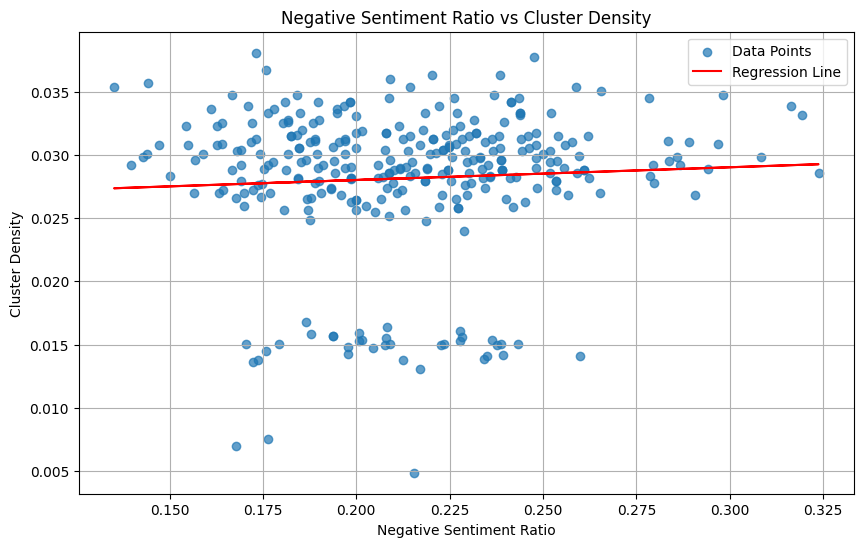

In [133]:
output_path = "plots/negative_user_ratio_vs_cluster_density.png"

plt.figure(figsize=(10, 6))
plt.scatter(
    df_clean["negative_user_ratio"], df_clean["density"], alpha=0.7, label="Data Points"
)
m, b = np.polyfit(
    df_clean["negative_user_ratio"], df_clean["density"], 1
)  # Regression line
plt.plot(
    df_clean["negative_user_ratio"],
    m * df_clean["negative_user_ratio"] + b,
    color="red",
    label="Regression Line",
)
plt.xlabel("Negative Sentiment Ratio")
plt.ylabel("Cluster Density")
plt.title("Negative Sentiment Ratio vs Cluster Density")
plt.legend()
plt.grid(True)
plt.savefig(output_path)
plt.show()